In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import math
%matplotlib inline

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
import lightgbm as lgb

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pwd


'/content'

In [4]:
train = pd.read_csv('./drive/MyDrive/competition_data/train.csv')
test = pd.read_csv('./drive/MyDrive/competition_data/test.csv')
submission = pd.read_csv('./drive/MyDrive/competition_data/submission.csv')

train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 70 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   index         15000 non-null  int64  
 1   Q1            14959 non-null  float64
 2   Q2            14931 non-null  float64
 3   Q3            14950 non-null  float64
 4   Q4            14929 non-null  float64
 5   Q5            14962 non-null  float64
 6   Q6            14952 non-null  float64
 7   Q7            14924 non-null  float64
 8   Q8            14952 non-null  float64
 9   Q9            14944 non-null  float64
 10  Q10           14928 non-null  float64
 11  Q11           14941 non-null  float64
 12  Q12           14933 non-null  float64
 13  Q13           14960 non-null  float64
 14  Q14           14964 non-null  float64
 15  Q15           14955 non-null  float64
 16  Q16           14967 non-null  float64
 17  Q17           14963 non-null  float64
 18  Q18           14937 non-nu

In [5]:
# 질문의 유형별로 분류
# VCL의 응답은 0, 1로
# question 1 ~ 5 사이의 값
# TIPI 1 ~ 7 사이의 값
VCL_columns = ['VCL' + str(x + 1) for x in range(16)]
question_columns = ['Q' + str(x + 1) for x in range(26)]
TIPI_columns = ['TIPI' + str(x + 1) for x in range(10)]

survey_columns = []
survey_columns.extend(question_columns)
survey_columns.extend(TIPI_columns)

# 카테고리별로 분류
categorical_columns = ['gender', 'engnat', 'hand', 'religion', 'orientation', 'voted', 'married', 'ASD', 'urban', 'country', 'nerdiness', 'education']
elapse_columns = ['introelapse', 'testelapse', 'surveyelapse', 'familysize']
numerical_columns = [column for column in train.columns if column not in categorical_columns]

# [카테고리 object] 결측값 -> 최빈값으로 변경
for category in categorical_columns:
    if category != 'nerdiness':
        train[category] = train[category].fillna(train[category].mode()[0])
        test[category] = test[category].fillna(test[category].mode()[0])
        train[category] = train[category].astype('str')
        test[category] = test[category].astype('str')
    else:
        train[category] = train[category].fillna(train[category].mode()[0])
        train[category] = train[category].astype('str')

    
# 연속형 변수 : float32, 결측값 -> 응답 : 3 (중간 값[이도저도 아니다])
for survey in survey_columns:
    train[survey] = train[survey].astype('float32')
    train[survey] = train[survey].fillna(3)
    test[survey] = test[survey].astype('float32')
    test[survey] = test[survey].fillna(3)

# 시간 관련 변수 -> 중앙값(중위값)으로 [median]
for elapse in elapse_columns:
    train[elapse] = train[elapse].astype('float32')
    train[elapse] = train[elapse].fillna(train[elapse].median())
    test[elapse] = test[elapse].astype('float32')
    test[elapse] = test[elapse].fillna(test[elapse].median())


In [6]:
# 마키아벨리즘에 대한 질문 점수
makia_survey = ['Q' + str(i+1) for i in range(26)]
not_makia = ['Q3', 'Q4', 'Q6','Q7', 'Q9', 'Q10', 'Q11', 'Q14', 'Q16', 'Q17', 'Q18',
            'Q21', 'Q22', 'Q23', 'Q23', 'Q24', 'Q25', 'Q26']

for columns in not_makia:
    train.loc[train[columns] > 0, columns] = 6 - train[columns]
    test.loc[test[columns] > 0, columns] = 6 - test[columns]



# 기준치 (60점 이상)에 관련된 파생변수 생성
train['makia_score'] = np.sum(train[makia_survey], axis = 1)
test['makia_score'] = np.sum(test[makia_survey], axis = 1)

train['high_makia'] = train['makia_score'].apply(lambda x : (1 if x > 60 else 0))
test['high_makia'] = test['makia_score'].apply(lambda x : (1 if x > 60 else 0))

train['high_makia'] = train['high_makia'].astype('str')
test['high_makia'] = test['high_makia'].astype('str')

In [7]:
'''
 TIPI에 대한 질문 점수
 TIPI는 1 ~ 7점까지 존재 -> 1 ~ 5점으로 변환
 TIPI 1점 -> 1점
 TIPI 2점 -> 2점
 TIPI 3점 -> 3점
 TIPI 4점 -> 3점
 TIPI 5점 -> 4점
 TIPI 6점 -> 4점 
 TIPI 7점 -> 5점
'''
TIPI_score = {1:1, 2:2, 3:4, 4:5, 4:6, 5:7}

for tipi in TIPI_columns:
    train[tipi] = train[tipi].map(TIPI_score)
    test[tipi] = test[tipi].map(TIPI_score)

train[TIPI_columns].describe()

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,3.386800,4.088200,4.790800,4.452200,5.448200,5.108400,4.881667,4.072067,4.273600,2.669067
std,1.882115,1.755551,1.643294,1.902163,1.441754,1.757097,1.651256,1.855704,1.761935,1.629395
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,2.000000,4.000000,1.000000
50%,4.000000,4.000000,4.000000,4.000000,6.000000,6.000000,4.000000,4.000000,4.000000,2.000000
75%,4.000000,6.000000,6.000000,6.000000,7.000000,7.000000,6.000000,6.000000,6.000000,4.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000


In [8]:
test[TIPI_columns].describe()

,TIPI1,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10
count,35452.000000,35452.000000,35452.000000,35452.000000,35452.00000,35452.000000,35452.000000,35452.000000,35452.000000,35452.000000
mean,3.379161,4.053509,4.762609,4.439439,5.45642,5.110741,4.895098,4.089163,4.284102,2.642446
std,1.894627,1.761814,1.658804,1.902973,1.44208,1.745227,1.671246,1.858550,1.772485,1.626898
min,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,4.000000,4.000000,4.000000,4.00000,4.000000,4.000000,2.000000,4.000000,1.000000
50%,4.000000,4.000000,4.000000,4.000000,6.00000,6.000000,4.000000,4.000000,4.000000,2.000000
75%,4.000000,6.000000,6.000000,6.000000,7.00000,7.000000,6.000000,6.000000,6.000000,4.000000
max,7.000000,7.000000,7.000000,7.000000,7.00000,7.000000,7.000000,7.000000,7.000000,7.000000


In [9]:
'''
TIPI 관련 파생변수 생성

성실성 : {3번 점수 + (8 - '8번 점수')} ÷ 2
우호성 : {7번 점수 + (8 - '2번 점수')} ÷ 2
정서적 안정성(점수가 낮으면 신경성과 관련): {9번 점수 + (8 - '4번 점수')} ÷ 2
개방성 : {5번 점수 + (8 - '10번 점수')} ÷ 2
외향성 : {1번 점수 + (8 - '6번 점수')} ÷ 2
'''

train['성실성'] = (train['TIPI3'] + 8 - train['TIPI8']) / 2
train['우호성'] = (train['TIPI7'] + 8- train['TIPI2']) / 2
train['정서적 안정성'] = (train['TIPI9'] + 8 - train['TIPI4']) / 2
train['개방성'] = (train['TIPI5'] + 8 - train['TIPI10']) / 2
train['외향성'] = (train['TIPI1'] + 8 - train['TIPI6']) / 2


test['성실성'] = (test['TIPI3'] + 8 - test['TIPI8']) / 2
test['우호성'] = (test['TIPI7'] + 8- test['TIPI2']) / 2
test['정서적 안정성'] = (test['TIPI9'] + 8 - test['TIPI4']) / 2
test['개방성'] = (test['TIPI5'] + 8 - test['TIPI10']) / 2
test['외향성'] = (test['TIPI1'] + 8 - test['TIPI6']) / 2

In [10]:

# EDA 결과 -> 50대 이상일수록 nerdiness = 1인 비율이 높음
# 연령대별로 분류

def age_to_category(age):
    if (age >= 0) & (age <= 18):
        return 'children'
    elif (age >= 19) & (age <= 39):
        return 'adult'
    elif (age >= 40) & (age <= 59):
        return 'middle age'
    else:
        return 'senior'

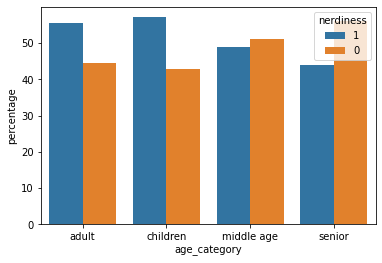

In [11]:
train['age_category'] = train['age'].apply(lambda x : age_to_category(x))
counts = train.groupby('age_category')['nerdiness'].value_counts(normalize = True).rename('percentage').mul(100).reset_index()
sns.barplot(x = 'age_category', y = 'percentage', hue = 'nerdiness', data = counts)
test['age_category'] = test['age'].apply(lambda x : age_to_category(x))


In [12]:
# 특정 종교와 관련하여 nerdiness 변화가 뚜렷함.
def convert_environment(x):
    if ((x == '2.0') | (x == '5.0') | (x == '9.0')):
        return '0'
    elif ((x == '1.0') | (x == '12.0') | (x == '6.0') | (x == '7.0')):
        return '1'
    else:
        return '2'


train['religion_environment'] = train['religion'].apply(lambda x : convert_environment(x))
test['religion_environment'] = test['religion'].apply(lambda x : convert_environment(x))

In [13]:
# age, religion -> 삭제
train.drop(['age', 'religion'], axis = 1, inplace = True)
test.drop(['age', 'religion'], axis = 1, inplace = True)

In [14]:
time = ['introelapse', 'testelapse', 'surveyelapse']
train[time].describe()


,introelapse,testelapse,surveyelapse
count,15000.000000,15000.000000,1.500000e+04
mean,767.137756,387.965668,2.787958e+03
std,13835.948242,8513.031250,1.785955e+05
min,1.000000,1.000000,3.000000e+00
25%,4.000000,82.000000,1.260000e+02
50%,10.000000,106.000000,1.640000e+02
75%,36.000000,140.000000,2.170000e+02
max,855030.000000,474572.000000,1.516699e+07



## 사분위를 이용하여 이상치 처리

![image.png](attachment:image.png)


In [15]:
# 위의 방식을 사용하여 연속형 변수 이상치(outlier) 처리
for time_columns in time:
    q1 = np.percentile(train[time_columns], 25)
    q3 = np.percentile(test[time_columns], 75)

    outlier_bounds = q3 + 1.5 * (q3 - q3)
    train.loc[train[time_columns] >= outlier_bounds, time_columns] = outlier_bounds
    test.loc[test[time_columns] >= outlier_bounds, time_columns] = outlier_bounds

train[time].describe()

,introelapse,testelapse,surveyelapse
count,15000.000000,15000.000000,15000.000000
mean,16.589001,105.538597,163.029663
std,14.381206,28.318846,44.735909
min,1.000000,1.000000,3.000000
25%,4.000000,82.000000,126.000000
50%,10.000000,106.000000,164.000000
75%,36.000000,140.000000,216.000000
max,38.000000,140.000000,216.000000


In [16]:
# familysize의 값을 최대치를 20으로 잡고, 20이 넘어갈 경우 모두 20으로 변경
train.loc[train.familysize >= 20, 'familysize'] = 20
test.loc[test.familysize >= 20, 'familysize'] = 20


In [17]:
# VCL 문제로 지능 수준을 파악
# 존재하지 않는 단어가 중간중간 포함되어 있음.

VCL_columns = ['VCL' + str(x+1) for x in range(16)]
VCL_not_exists = ['VCL6', 'VCL9', 'VCL12']
VCL_exists = [column for column in VCL_columns if column not in VCL_not_exists]

train['지능'] = (train[VCL_exists].sum(axis = 1) / len(VCL_columns)) + (3 - train[VCL_not_exists].sum(axis = 1)) / len(VCL_columns)
test['지능'] = (test[VCL_exists].sum(axis = 1) / len(VCL_columns)) + (3 - test[VCL_not_exists].sum(axis = 1)) / len(VCL_columns)

train['fake'] = train['VCL6'] + train['VCL9'] + train['VCL12']
test['fake'] = test['VCL6'] + test['VCL9'] + test['VCL12']

In [18]:

train.drop(VCL_columns, axis = 1, inplace = True)
test.drop(VCL_columns, axis = 1, inplace = True)

numeric_columns = train.columns[train.dtypes != 'object']
numeric_columns

categorical_columns = train.columns[(train.dtypes == 'object') & (train.columns != 'nerdiness')]
len(categorical_columns), len(numeric_columns)

(13, 49)

In [19]:
train.to_csv('./drive/MyDrive/competition_data/EDA_VCLDrop_train.csv', index = False)
test.to_csv('./drive/MyDrive/competition_data/EDA_VCLDrop_test.csv', index = False)

In [20]:
for numeric in numeric_columns:
    print('{0} column의 왜도 {1:.4f}'.format(numeric, train[numeric].skew()))


index column의 왜도 0.0000
Q1 column의 왜도 -0.9885
Q2 column의 왜도 -1.1972
Q3 column의 왜도 1.4591
Q4 column의 왜도 0.7707
Q5 column의 왜도 -0.9031
Q6 column의 왜도 0.6339
Q7 column의 왜도 1.3420
Q8 column의 왜도 -0.9678
Q9 column의 왜도 0.9139
Q10 column의 왜도 1.1142
Q11 column의 왜도 0.1606
Q12 column의 왜도 -0.8517
Q13 column의 왜도 -0.6511
Q14 column의 왜도 0.5904
Q15 column의 왜도 -0.0703
Q16 column의 왜도 0.3775
Q17 column의 왜도 0.8841
Q18 column의 왜도 1.0026
Q19 column의 왜도 -0.3849
Q20 column의 왜도 -0.4999
Q21 column의 왜도 0.0159
Q22 column의 왜도 -0.5872
Q23 column의 왜도 -0.9040
Q24 column의 왜도 1.4714
Q25 column의 왜도 0.1770
Q26 column의 왜도 1.2057
introelapse column의 왜도 0.5403
testelapse column의 왜도 -0.2148
surveyelapse column의 왜도 -0.3079
TIPI1 column의 왜도 0.3339
TIPI2 column의 왜도 -0.1228
TIPI3 column의 왜도 -0.3808
TIPI4 column의 왜도 -0.2544
TIPI5 column의 왜도 -0.6134
TIPI6 column의 왜도 -0.6334
TIPI7 column의 왜도 -0.3970
TIPI8 column의 왜도 -0.0578
TIPI9 column의 왜도 -0.1382
TIPI10 column의 왜도 0.7056
familysize column의 왜도 2.6367
makia_score column의 왜도 0.3230
성실

In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train[numeric_columns])
x_scaled = pd.DataFrame(scaler.transform(train[numeric_columns]), columns = numeric_columns)
x_test_scaled = pd.DataFrame(scaler.transform(test[numeric_columns]), columns = numeric_columns)

train_data = pd.concat([train[categorical_columns], x_scaled], axis = 1)
test_data = pd.concat([test[categorical_columns], x_test_scaled], axis = 1)
train_data.shape, test_data.shape

((15000, 62), (35452, 62))

In [22]:
train_data.drop(['country', 'ASD', 'high_makia'], axis = 1, inplace = True)
test_data.drop(['country', 'ASD', 'high_makia'], axis = 1, inplace = True)

In [23]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


label_categorical_columns = ['urban', 'gender', 'engnat', 'hand','voted', 'married', 'age_category', 'religion_environment'] + question_columns
onehot_categorical_columns = ['education', 'orientation']
categorical_columns = [] + label_categorical_columns + onehot_categorical_columns
numerical_columns = [columns for columns in test.columns if columns not in ([] + label_categorical_columns + onehot_categorical_columns)]

for label in label_categorical_columns:
    le = LabelEncoder()
    le.fit(train_data[label])
    train_data[label] = le.transform(train_data[label])
    test_data[label] = le.transform(test_data[label])

for onehot in onehot_categorical_columns:
    train_data = pd.get_dummies(train_data, columns = [onehot])
    test_data = pd.get_dummies(test_data, columns = [onehot])

In [24]:
from sklearn.model_selection import train_test_split, cross_val_score

X = train_data
y = train['nerdiness']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size= 0.2, random_state = 42, stratify = y)

In [26]:
!pip install optuna
# optuna를 사용하여 하이퍼 파라미터 최적화

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 348.5/348.5 KB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.0/81.0 KB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.1/147.1 KB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 KB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 13.2 MB/s eta 0:00:00
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11136 sha256=9cbe07609e0f462107554e04cd3f2ead590078abd733b19c99c6a3f83e6021d8
  Stored in directory: /root/.cache/pip/wheels/7f/1a/65/84ff8c386bec21fca6d220ea1f5498a0367883a78dd5ba6122
Successfully built pyperclip
  A

In [47]:
from sklearn.model_selection import StratifiedKFold
def tune_model(model_type, X, Y, n_trials=10, cv=10):
    skf = StratifiedKFold(n_splits=cv)
    
    if model_type=='lgbm':
        def objective(trial):
            params = {
                'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
                'learning_rate' : trial.suggest_float('learning_rate', 0.05, 0.3),
                'num_leaves' : trial.suggest_int('num_leaves', 7, 255),
                'reg_alpha' : trial.suggest_float('reg_alpha', 0.0, 1.0),
                'reg_lambda' : trial.suggest_float('reg_lambda', 0.0, 1.0),
                'colsample_bytree' : trial.suggest_float('colsample_bytree', 0, 1),
                'subsample' : trial.suggest_float('subsample', 0, 1)
              }
            model = lgb.LGBMClassifier(metric='auc', random_state=42, **params)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
    
        
    elif model_type=='rf':
        def objective(trial):
            params = {
                'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
                'max_depth' : trial.suggest_int('max_depth', 3, 100),
                'max_features' : trial.suggest_float('max_features', 0, 1),
                'criterion' : trial.suggest_categorical('criterion', ['gini','entropy'])
                }
            model = RandomForestClassifier(random_state=42, **params, n_jobs=-1)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
        
        
    elif model_type=='ets':
        def objective(trial):
            params = {
                'n_estimators' : trial.suggest_int('n_estimators', 100, 1000),
                'max_depth' : trial.suggest_int('max_depth', 3, 100),
                'max_features' : trial.suggest_float('max_features', 0, 1),
                'criterion' : trial.suggest_categorical('criterion', ['gini','entropy'])
                }
            model = ExtraTreesClassifier(random_state=42, **params, n_jobs=-1)
            score = cross_val_score(model, X, Y, cv=skf, scoring='roc_auc').mean()
            
            return score
        
    
    sampler = TPESampler(seed=42)
    study=optuna.create_study(direction='maximize', 
                              sampler = sampler)
    study.optimize(objective, n_trials=n_trials)
    print(f"Model : {model_type}, Best Score : {study.best_value}, Best Params : {study.best_params}")
    return study.best_params

In [43]:
lgb_params = tune_model('lgbm', X, y, n_trials= 10)

[I 2023-01-17 13:21:02,276] A new study created in memory with name: no-name-15c0b896-62f6-4508-b013-f2e098e0a833
[I 2023-01-17 13:21:19,795] Trial 0 finished with value: 0.8630253386674827 and parameters: {'n_estimators': 437, 'learning_rate': 0.28767857660247903, 'num_leaves': 189, 'reg_alpha': 0.5986584841970366, 'reg_lambda': 0.15601864044243652, 'colsample_bytree': 0.15599452033620265, 'subsample': 0.05808361216819946}. Best is trial 0 with value: 0.8630253386674827.
[I 2023-01-17 13:23:22,137] Trial 1 finished with value: 0.8720495689332515 and parameters: {'n_estimators': 880, 'learning_rate': 0.20027875293580222, 'num_leaves': 183, 'reg_alpha': 0.020584494295802447, 'reg_lambda': 0.9699098521619943, 'colsample_bytree': 0.8324426408004217, 'subsample': 0.21233911067827616}. Best is trial 1 with value: 0.8720495689332515.
[I 2023-01-17 13:23:34,647] Trial 2 finished with value: 0.8572014392112888 and parameters: {'n_estimators': 263, 'learning_rate': 0.09585112746335846, 'num_lea

Model : lgbm, Best Score : 0.8738524786914244, Best Params : {'n_estimators': 633, 'learning_rate': 0.061612603179999434, 'num_leaves': 158, 'reg_alpha': 0.17052412368729153, 'reg_lambda': 0.06505159298527952, 'colsample_bytree': 0.9488855372533332, 'subsample': 0.9656320330745594}


In [46]:
rf_params = tune_model('rf', X, y, n_trials=10)

[I 2023-01-17 13:26:48,004] A new study created in memory with name: no-name-323d3ba3-b386-4fa9-9c55-2684ab715102
[I 2023-01-17 13:34:05,978] Trial 0 finished with value: 0.8749509141102265 and parameters: {'n_estimators': 437, 'max_depth': 96, 'max_features': 0.7319939418114051, 'criterion': 'gini'}. Best is trial 0 with value: 0.8749509141102265.
[I 2023-01-17 13:37:03,639] Trial 1 finished with value: 0.8102585287479933 and parameters: {'n_estimators': 240, 'max_depth': 8, 'max_features': 0.8661761457749352, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8749509141102265.
[I 2023-01-17 13:39:13,337] Trial 2 finished with value: 0.8700068543065609 and parameters: {'n_estimators': 118, 'max_depth': 98, 'max_features': 0.8324426408004217, 'criterion': 'gini'}. Best is trial 0 with value: 0.8749509141102265.
[I 2023-01-17 13:42:17,779] Trial 3 finished with value: 0.8762968230505331 and parameters: {'n_estimators': 265, 'max_depth': 32, 'max_features': 0.5247564316322378, 'crite

Model : rf, Best Score : 0.8867352893814383, Best Params : {'n_estimators': 828, 'max_depth': 32, 'max_features': 0.09767211400638387, 'criterion': 'gini'}


In [48]:
ets_params = tune_model('ets', X, y, n_trials=10)

[I 2023-01-17 14:11:17,468] A new study created in memory with name: no-name-0893e27f-f918-4b35-8c95-1e660f1b13e6
[I 2023-01-17 14:16:19,959] Trial 0 finished with value: 0.8883187135482752 and parameters: {'n_estimators': 437, 'max_depth': 96, 'max_features': 0.7319939418114051, 'criterion': 'gini'}. Best is trial 0 with value: 0.8883187135482752.
[I 2023-01-17 14:18:01,961] Trial 1 finished with value: 0.8094583300927944 and parameters: {'n_estimators': 240, 'max_depth': 8, 'max_features': 0.8661761457749352, 'criterion': 'entropy'}. Best is trial 0 with value: 0.8883187135482752.
[I 2023-01-17 14:19:34,931] Trial 2 finished with value: 0.8860839725700048 and parameters: {'n_estimators': 118, 'max_depth': 98, 'max_features': 0.8324426408004217, 'criterion': 'gini'}. Best is trial 0 with value: 0.8883187135482752.
[I 2023-01-17 14:21:52,633] Trial 3 finished with value: 0.8892409741904391 and parameters: {'n_estimators': 265, 'max_depth': 32, 'max_features': 0.5247564316322378, 'crite

Model : ets, Best Score : 0.8908690309775743, Best Params : {'n_estimators': 828, 'max_depth': 32, 'max_features': 0.09767211400638387, 'criterion': 'gini'}


In [49]:
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier
import lightgbm as lgbm
from sklearn.model_selection import train_test_split, cross_val_score

ets_params = {'n_estimators': 828, 'max_depth': 32, 'max_features': 0.09767211400638387, 'criterion': 'gini'}
rf_params =  {'n_estimators': 828, 'max_depth': 32, 'max_features': 0.09767211400638387, 'criterion': 'gini'}
lgbm_params = {'n_estimators': 633, 'learning_rate': 0.061612603179999434, 'num_leaves': 158, 'reg_alpha': 0.17052412368729153, 'reg_lambda': 0.06505159298527952, 'colsample_bytree': 0.9488855372533332, 'subsample': 0.9656320330745594}

ex_clf = ExtraTreesClassifier(**ets_params, random_state = 42)
rf_clf = RandomForestClassifier(**rf_params, random_state = 42)
tuned_lgbm=lgbm.LGBMClassifier(objective="binary", random_state=42, **lgbm_params)

vt_clf = VotingClassifier(estimators = [
        ('lgbm', tuned_lgbm),
        ('rf', rf_clf),
        ('ex', ets_params),
    ], weights = (2, 1, 7), voting = 'soft')

score = cross_val_score(vt_clf, X, y, cv = 10, scoring = 'roc_auc')
score.mean(), score.std()

/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 10.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_voting.py", line 324, in fit
    return super().fit(X, transformed_y, sample_weight)
  File "/usr/local/lib/python3.8/dist-packages/sklearn/ensemble/_voting.py", line 65, in fit
    names, clfs = self._validate_estimators()
  File "/usr/local/lib/python

(nan, nan)

In [50]:
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, RandomForestClassifier
import lightgbm as lgb

ets_params = {'n_estimators': 500, 'max_depth': 75, 'max_features': 0.20222465942018208, 'criterion': 'entropy'}
rf_params =  {'n_estimators': 828, 'max_depth': 32, 'max_features': 0.09767211400638387, 'criterion': 'gini'}
lgb_params = {'n_estimators': 189, 'learning_rate': 0.06550029428021084, 'num_leaves': 249, 'reg_alpha': 0.00011906936480932443, 'reg_lambda': 0.00012169645168232884, 'colsample_bytree': 0.2231374650653746, 'subsample': 0.18089704448751198}

ex_clf = ExtraTreesClassifier(**ets_params, random_state = 42)
rf_clf = RandomForestClassifier(**rf_params, random_state = 42)
tuned_lgbm=lgb.LGBMClassifier(objective="binary", random_state=42, **lgb_params)

vt_clf = VotingClassifier(estimators = [
        ('lgbm', tuned_lgbm),
        ('rf', rf_clf),
        ('ex', ex_clf),
    ], weights = (2, 1, 7), voting = 'soft')

vt_clf.fit(X, y)

predictions = vt_clf.predict_proba(test_data)[:, 1]
submission['nerdiness'] = predictions
submission

,index,nerdiness
0,0,0.060475
1,1,0.820511
2,2,0.861263
3,3,0.605669
4,4,0.912110
...,...,...
35447,35447,0.926324
35448,35448,0.707263
35449,35449,0.921889
35450,35450,0.090586


In [51]:
vt_clf = VotingClassifier(estimators = [
    ('lgbm', tuned_lgbm),
    ('rf', rf_clf)
], weights = (7, 3), voting = 'soft')

vt_clf.fit(X, y)

predictions = vt_clf.predict_proba(test_data)[:, 1]
submission['nerdiness'] = predictions
submission

,index,nerdiness
0,0,0.193236
1,1,0.868422
2,2,0.928668
3,3,0.659997
4,4,0.796233
...,...,...
35447,35447,0.827106
35448,35448,0.814503
35449,35449,0.943169
35450,35450,0.180724


In [54]:
submission.to_csv('./drive/MyDrive/competition_data/submission.csv')